In [447]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc

from constants import CONSTS as CS

In [448]:
CS = {
    'x_lim': np.array([-10, 10]),
    'y_lim': np.array([-10, 10]),
    'theta_lim': np.array([-np.pi, np.pi]),
    'xp_lim': np.array([-15, 15]),
    'yp_lim': np.array([-15, 15]),
    'num_waypoints': 10,
    'waypoint_tol': 0.2,
    'angle_tol': 0.2,
    'wheelbase': 0.335,
    'max_acc': 3,
    'max_steering_angle': 0.5,
    'max_vel': 10
}


In [449]:
wps = np.array([
        [0, 0, 0],
        [ 8.62844369,  4.89809566,  1.53850753],
        [-3.3128731 , -8.41245037,  0.2807953 ],
        [ 6.42118345,  9.56369873, -0.52140243],
        [-3.55531364, -7.33024669, -0.58341082],
        [-4.72198946, -4.64057374, -1.95494644],
        [-1.21513531, -4.07460913, -1.61876955],
        [-4.51332572,  9.87373577,  0.22790191],
        [-6.26747526, -9.75024744, -1.55346495],
        [ 7.99872313, -0.73949926, -2.41688927],
        [-9.2515838 ,  6.51287078, -0.61068366]
])

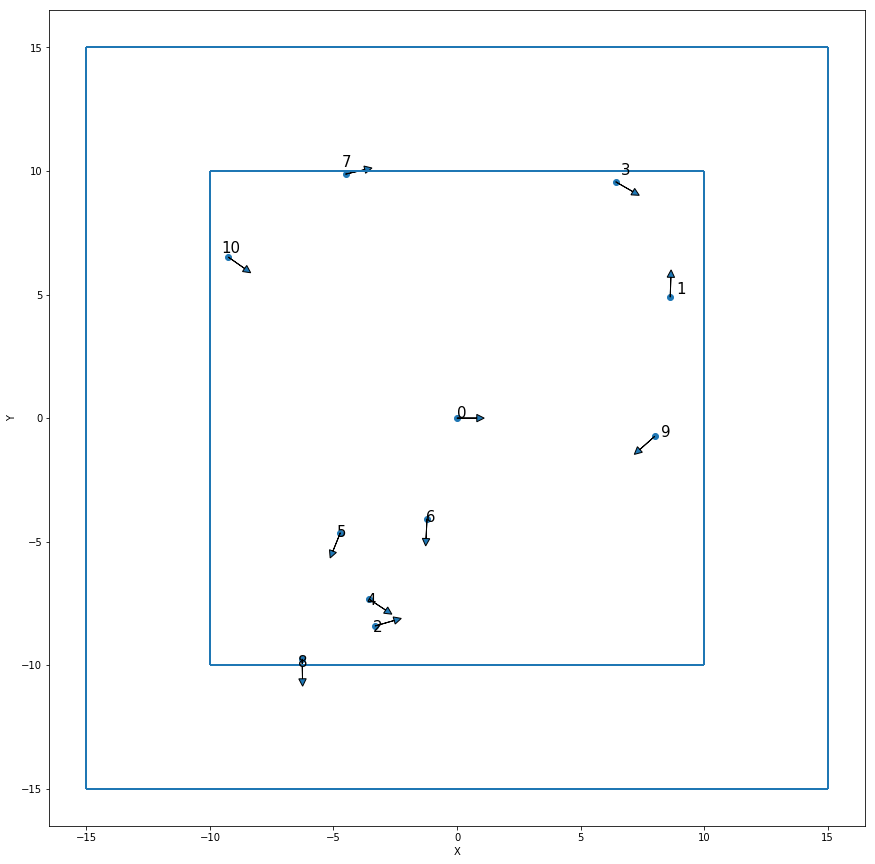

In [450]:
arrow_length = 0.8

plt.figure(figsize=(15, 15))
ax = plt.gca()

plt.scatter(wps[:, 0], wps[:, 1])
for i, wp in enumerate(wps):
    tip = arrow_length * np.array([np.cos(wp[2]), np.sin(wp[2])])
    ax.arrow(wp[0], wp[1], tip[0], tip[1], head_width=0.3, head_length=0.3)
    
    ax.text(wp[0] * 1.03, wp[1] * 1.03, '{}'.format(i), fontsize=15)

lines = [
    [(CS['x_lim'][0], CS['y_lim'][0]), (CS['x_lim'][0], CS['y_lim'][1])], 
    [(CS['x_lim'][0], CS['y_lim'][0]), (CS['x_lim'][1], CS['y_lim'][0])], 
    [(CS['x_lim'][1], CS['y_lim'][1]), (CS['x_lim'][0], CS['y_lim'][1])], 
    [(CS['x_lim'][1], CS['y_lim'][1]), (CS['x_lim'][1], CS['y_lim'][0])], 
    [(CS['xp_lim'][0], CS['yp_lim'][0]), (CS['xp_lim'][0], CS['yp_lim'][1])], 
    [(CS['xp_lim'][0], CS['yp_lim'][0]), (CS['xp_lim'][1], CS['yp_lim'][0])], 
    [(CS['xp_lim'][1], CS['yp_lim'][1]), (CS['xp_lim'][0], CS['yp_lim'][1])], 
    [(CS['xp_lim'][1], CS['yp_lim'][1]), (CS['xp_lim'][1], CS['yp_lim'][0])], 
]
lc = mc.LineCollection(lines, linewidths=2)
ax.add_collection(lc)

plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(CS['xp_lim'] * 1.1)
plt.ylim(CS['yp_lim'] * 1.1)

ax.set_aspect('equal')
plt.show()

In [451]:
def cubic_hermite(ts, x0, x1, v0, v1):
    '''
    From https://www.rose-hulman.edu/~finn/CCLI/Notes/day09.pdf
    '''
    t2 = ts * ts
    t3 = t2 * ts
    
    H0 = 1 - 3*t2 + 2*t3
    H1 = ts - 2*t2 + t3
    H2 = -t2 + t3
    H3 = 3*t2 - 2*t3
    
    return H0.reshape(-1, 1) * x0 + H1.reshape(-1, 1) * v0 + H2.reshape(-1, 1) * v1 + H3.reshape(-1, 1) * x1

def cubic_hermite_d(ts, x0, x1, v0, v1):
    t2 = ts * ts
    t3 = t2 * ts
    
    H0 = - 6*ts + 6*t2
    H1 = np.ones_like(ts) - 4*ts + 3*t2
    H2 = -2*ts + 3*t2
    H3 = 6*ts - 6*t2
    
    return H0.reshape(-1, 1) * x0 + H1.reshape(-1, 1) * v0 + H2.reshape(-1, 1) * v1 + H3.reshape(-1, 1) * x1    

In [452]:
cur_x = np.array([0, 0])
cur_v = np.array([1, 0])

trajs = []
d_trajs = []
speed = 30
n_pts = 30
ts = np.linspace(0, 1, n_pts)

vs = np.c_[np.cos(wps[:,2]), np.sin(wps[:,2])]
for i, wp in enumerate(wps):
    next_x = wp[:2]
    next_v = speed * vs[i]
    if i == len(wps) - 1:
        next_v *= 0
    
    traj = cubic_hermite(ts, cur_x, next_x, cur_v, next_v)
    trajs.append(traj)
    
    d_traj = cubic_hermite_d(ts, cur_x, next_x, cur_v, next_v)
    d_trajs.append(d_traj)
    
    cur_x, cur_v = next_x, next_v    

trajs = np.array(trajs)
d_trajs = np.array(d_trajs)

In [454]:
def plot_trajs(trajs, d_trajs):
    plt.figure(figsize=(15, 15))
    ax = plt.gca()

    for i, traj in enumerate(trajs):
        plt.scatter(traj[:,0], traj[:,1])

        for j, pt in enumerate(traj):
            d_pt = d_trajs[i, j] * 0.05
            ax.arrow(pt[0], pt[1], d_pt[0], d_pt[1], head_width=0.2, head_length=0.2)

    arrow_length = 0.8

    plt.scatter(wps[:, 0], wps[:, 1])
    for i, wp in enumerate(wps):
        tip = arrow_length * np.array([np.cos(wp[2]), np.sin(wp[2])])
        ax.arrow(wp[0], wp[1], tip[0], tip[1], head_width=0.3, head_length=0.3)

        ax.text(wp[0] * 1.03, wp[1] * 1.03, '{}'.format(i), fontsize=15)

    lines = [
        [(CS['x_lim'][0], CS['y_lim'][0]), (CS['x_lim'][0], CS['y_lim'][1])], 
        [(CS['x_lim'][0], CS['y_lim'][0]), (CS['x_lim'][1], CS['y_lim'][0])], 
        [(CS['x_lim'][1], CS['y_lim'][1]), (CS['x_lim'][0], CS['y_lim'][1])], 
        [(CS['x_lim'][1], CS['y_lim'][1]), (CS['x_lim'][1], CS['y_lim'][0])], 
        [(CS['xp_lim'][0], CS['yp_lim'][0]), (CS['xp_lim'][0], CS['yp_lim'][1])], 
        [(CS['xp_lim'][0], CS['yp_lim'][0]), (CS['xp_lim'][1], CS['yp_lim'][0])], 
        [(CS['xp_lim'][1], CS['yp_lim'][1]), (CS['xp_lim'][0], CS['yp_lim'][1])], 
        [(CS['xp_lim'][1], CS['yp_lim'][1]), (CS['xp_lim'][1], CS['yp_lim'][0])], 
    ]
    lc = mc.LineCollection(lines, linewidths=2)
    ax.add_collection(lc)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(CS['xp_lim'] * 1.1)
    plt.ylim(CS['yp_lim'] * 1.1)

    ax.set_aspect('equal')
    plt.show()

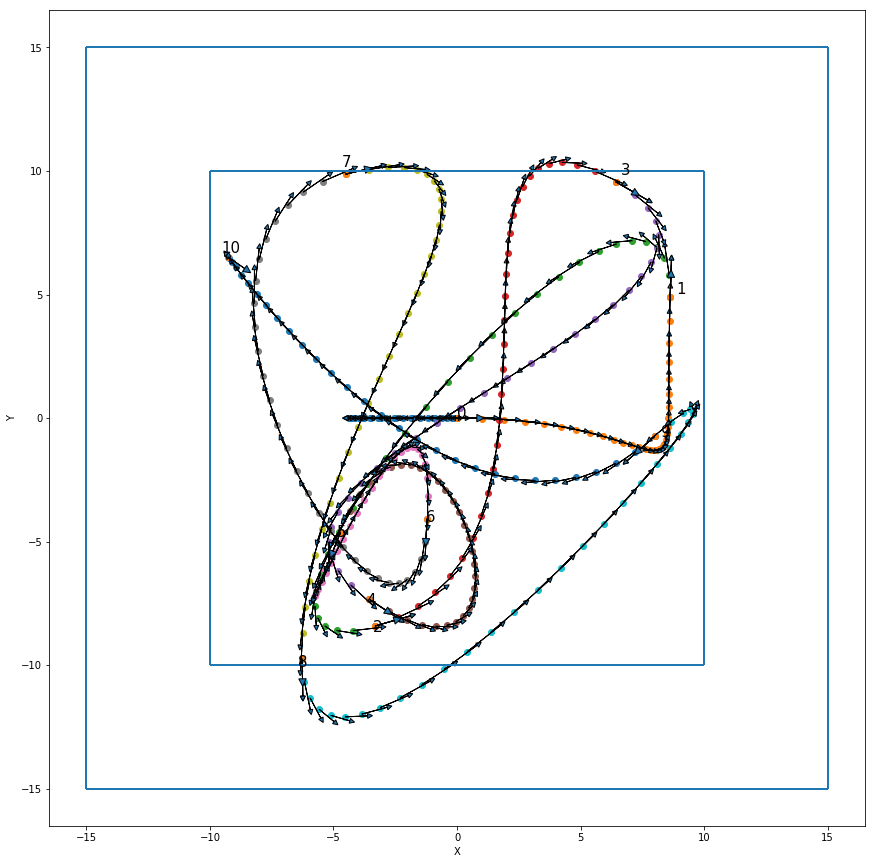

In [455]:
plot_trajs(trajs, d_trajs)

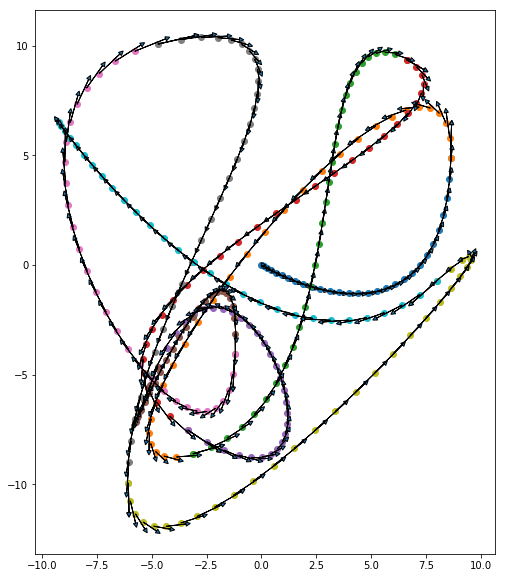

In [436]:
plot_trajs(trajs, d_trajs)

In [432]:
trajs = np.array([[[ 0.00000000e+00,  0.00000000e+00],
        [ 2.92812288e-02, -1.73530709e-02],
        [ 1.13765463e-01, -6.61012530e-02],
        [ 2.49448046e-01, -1.41278014e-01],
        [ 4.32324231e-01, -2.37916768e-01],
        [ 6.58389330e-01, -3.51051062e-01],
        [ 9.23638821e-01, -4.75714266e-01],
        [ 1.22406757e+00, -6.06939852e-01],
        [ 1.55567157e+00, -7.39761293e-01],
        [ 1.91444540e+00, -8.69211912e-01],
        [ 2.29638481e+00, -9.90325570e-01],
        [ 2.69748545e+00, -1.09813523e+00],
        [ 3.11374211e+00, -1.18767464e+00],
        [ 3.54114962e+00, -1.25397730e+00],
        [ 3.97570419e+00, -1.29207659e+00],
        [ 4.41340065e+00, -1.29700565e+00],
        [ 4.85023499e+00, -1.26379800e+00],
        [ 5.28220177e+00, -1.18748784e+00],
        [ 5.70529556e+00, -1.06310773e+00],
        [ 6.11551380e+00, -8.85692596e-01],
        [ 6.50885010e+00, -6.50273561e-01],
        [ 6.88130093e+00, -3.51885557e-01],
        [ 7.22886133e+00,  1.44381523e-02],
        [ 7.54752636e+00,  4.53665257e-01],
        [ 7.83329105e+00,  9.70759869e-01],
        [ 8.08214855e+00,  1.57068992e+00],
        [ 8.29009914e+00,  2.25842261e+00],
        [ 8.45313454e+00,  3.03892374e+00],
        [ 8.56725025e+00,  3.91715717e+00],
        [ 8.62844372e+00,  4.89809561e+00]],

       [[ 8.62844372e+00,  4.89809561e+00],
        [ 8.59003639e+00,  5.80672932e+00],
        [ 8.41612053e+00,  6.47525597e+00],
        [ 8.11884499e+00,  6.91944599e+00],
        [ 7.71035433e+00,  7.15506840e+00],
        [ 7.20280170e+00,  7.19789314e+00],
        [ 6.60833120e+00,  7.06368971e+00],
        [ 5.93909359e+00,  6.76822853e+00],
        [ 5.20723534e+00,  6.32727909e+00],
        [ 4.42490387e+00,  5.75660992e+00],
        [ 3.60424948e+00,  5.07199144e+00],
        [ 2.75741816e+00,  4.28919268e+00],
        [ 1.89655840e+00,  3.42398429e+00],
        [ 1.03381944e+00,  2.49213719e+00],
        [ 1.81348681e-01,  1.50941849e+00],
        [-6.48705840e-01,  4.91598129e-01],
        [-1.44419730e+00, -5.45552254e-01],
        [-2.19297600e+00, -1.58626556e+00],
        [-2.88289332e+00, -2.61476755e+00],
        [-3.50180387e+00, -3.61529613e+00],
        [-4.03755760e+00, -4.57207441e+00],
        [-4.47800541e+00, -5.46933460e+00],
        [-4.81100416e+00, -6.29131174e+00],
        [-5.02440071e+00, -7.02223206e+00],
        [-5.10604954e+00, -7.64632607e+00],
        [-5.04379654e+00, -8.14781666e+00],
        [-4.82550526e+00, -8.51095009e+00],
        [-4.43901730e+00, -8.71994400e+00],
        [-3.87219024e+00, -8.75903511e+00],
        [-3.11287308e+00, -8.61245060e+00]],

       [[-3.11287308e+00, -8.61245060e+00],
        [-2.29604173e+00, -8.31119728e+00],
        [-1.56123698e+00, -7.90302849e+00],
        [-9.03164983e-01, -7.39729548e+00],
        [-3.16529155e-01, -6.80334568e+00],
        [ 2.03965098e-01, -6.13053465e+00],
        [ 6.63613141e-01, -5.38820982e+00],
        [ 1.06771088e+00, -4.58572435e+00],
        [ 1.42155242e+00, -3.73242855e+00],
        [ 1.73043466e+00, -2.83767128e+00],
        [ 1.99965119e+00, -1.91080570e+00],
        [ 2.23449850e+00, -9.61181879e-01],
        [ 2.44027185e+00,  1.84988976e-03],
        [ 2.62226582e+00,  9.68936682e-01],
        [ 2.78577566e+00,  1.93072915e+00],
        [ 2.93609667e+00,  2.87787628e+00],
        [ 3.07852697e+00,  3.80102921e+00],
        [ 3.21835709e+00,  4.69083357e+00],
        [ 3.36088562e+00,  5.53793812e+00],
        [ 3.51140547e+00,  6.33299637e+00],
        [ 3.67521477e+00,  7.06665468e+00],
        [ 3.85760832e+00,  7.72956181e+00],
        [ 4.06387949e+00,  8.31236935e+00],
        [ 4.29932451e+00,  8.80572414e+00],
        [ 4.56923914e+00,  9.20027637e+00],
        [ 4.87891769e+00,  9.48666859e+00],
        [ 5.23365736e+00,  9.65556335e+00],
        [ 5.63875151e+00,  9.69759941e+00],
        [ 6.09949255e+00,  9.60342693e+00],
        [ 6.62118340e+00,  9.36369896e+00]],

       [[ 6.62118340e+00,  9.36369896e+00],
        [ 7.07153368e+00,  9.03138256e+00],
        [ 7.32510042e+00,  8.66674900e+00],
        [ 7.39744663e+00,  8.27140427e+00],
        [ 7.30413055e+00,  7.84695148e+00],
        [ 7.06071281e+00,  7.39499855e+00],
        [ 6.68275261e+00,  6.91714668e+00],
        [ 6.18581295e+00,  6.41500282e+00],
        [ 5.58545160e+00,  5.89017105e+00],
        [ 4.89722919e+00,  5.34425449e+00],
        [ 4.13670635e+00,  4.77886200e+00],
        [ 3.31944275e+00,  4.19559383e+00],
        [ 2.46099758e+00,  3.59605646e+00],
        [ 1.57693386e+00,  2.98185539e+00],
        [ 6.82810307e-01,  2.35459614e+00],
        [-2.05813885e-01,  1.71588063e+00],
        [-1.07337689e+00,  1.06731415e+00],
        [-1.90431976e+00,  4.10503387e-01],
        [-2.68308020e+00, -2.52947330e-01],
        [-3.39410257e+00, -9.21434402e-01],
        [-4.02182198e+00, -1.59335327e+00],
        [-4.55067921e+00, -2.26709890e+00],
        [-4.96511745e+00, -2.94106722e+00],
        [-5.24957323e+00, -3.61365175e+00],
        [-5.38848782e+00, -4.28324938e+00],
        [-5.36629391e+00, -4.94825029e+00],
        [-5.16744518e+00, -5.60705900e+00],
        [-4.77636909e+00, -6.25806379e+00],
        [-4.17751408e+00, -6.89965868e+00],
        [-3.35531354e+00, -7.53024673e+00]],

       [[-3.35531354e+00, -7.53024673e+00],
        [-2.47175717e+00, -8.07046032e+00],
        [-1.69613218e+00, -8.45049095e+00],
        [-1.02383375e+00, -8.68305683e+00],
        [-4.50254917e-01, -8.78087711e+00],
        [ 2.92101502e-02, -8.75667477e+00],
        [ 4.19167519e-01, -8.62316799e+00],
        [ 7.24223673e-01, -8.39307690e+00],
        [ 9.48983014e-01, -8.07912254e+00],
        [ 1.09805429e+00, -7.69402218e+00],
        [ 1.17604136e+00, -7.25049925e+00],
        [ 1.18755114e+00, -6.76127243e+00],
        [ 1.13718939e+00, -6.23905945e+00],
        [ 1.02956271e+00, -5.69658422e+00],
        [ 8.69276762e-01, -5.14656353e+00],
        [ 6.60937071e-01, -4.60171986e+00],
        [ 4.09151077e-01, -4.07477188e+00],
        [ 1.18524075e-01, -3.57843924e+00],
        [-2.06336737e-01, -3.12544394e+00],
        [-5.60829163e-01, -2.72850204e+00],
        [-9.40342188e-01, -2.40033770e+00],
        [-1.34027147e+00, -2.15367007e+00],
        [-1.75601339e+00, -2.00121641e+00],
        [-2.18296051e+00, -1.95569897e+00],
        [-2.61650443e+00, -2.02983713e+00],
        [-3.05203915e+00, -2.23635530e+00],
        [-3.48496294e+00, -2.58796477e+00],
        [-3.91066575e+00, -3.09739327e+00],
        [-4.32454395e+00, -3.77735329e+00],
        [-4.72198963e+00, -4.64057350e+00]],

       [[-4.72198963e+00, -4.64057350e+00],
        [-5.06953382e+00, -5.49828291e+00],
        [-5.34000826e+00, -6.16289616e+00],
        [-5.53825760e+00, -6.64890957e+00],
        [-5.66912699e+00, -6.97081423e+00],
        [-5.73746252e+00, -7.14310169e+00],
        [-5.74810886e+00, -7.18026686e+00],
        [-5.70591164e+00, -7.09680223e+00],
        [-5.61571693e+00, -6.90719938e+00],
        [-5.48236847e+00, -6.62595224e+00],
        [-5.31071329e+00, -6.26755381e+00],
        [-5.10559559e+00, -5.84649611e+00],
        [-4.87186146e+00, -5.37727213e+00],
        [-4.61435556e+00, -4.87437534e+00],
        [-4.33792353e+00, -4.35229874e+00],
        [-4.04741049e+00, -3.82553244e+00],
        [-3.74766254e+00, -3.30857372e+00],
        [-3.44352388e+00, -2.81591153e+00],
        [-3.13984108e+00, -2.36204171e+00],
        [-2.84145784e+00, -1.96145296e+00],
        [-2.55322146e+00, -1.62864280e+00],
        [-2.27997637e+00, -1.37810278e+00],
        [-2.02656651e+00, -1.22432303e+00],
        [-1.79783881e+00, -1.18179822e+00],
        [-1.59863830e+00, -1.26502132e+00],
        [-1.43381286e+00, -1.48848915e+00],
        [-1.30820251e+00, -1.86668587e+00],
        [-1.22665679e+00, -2.41411209e+00],
        [-1.19401884e+00, -3.14525223e+00],
        [-1.21513534e+00, -4.07460928e+00]],

       [[-1.21513534e+00, -4.07460928e+00],
        [-1.31184244e+00, -4.99729490e+00],
        [-1.49636769e+00, -5.70707273e+00],
        [-1.75914431e+00, -6.21640587e+00],
        [-2.09060335e+00, -6.53775406e+00],
        [-2.48117781e+00, -6.68358040e+00],
        [-2.92129993e+00, -6.66634464e+00],
        [-3.40140152e+00, -6.49851036e+00],
        [-3.91191530e+00, -6.19253635e+00],
        [-4.44327259e+00, -5.76088524e+00],
        [-4.98590660e+00, -5.21601915e+00],
        [-5.53024912e+00, -4.57039833e+00],
        [-6.06673336e+00, -3.83648443e+00],
        [-6.58578968e+00, -3.02674055e+00],
        [-7.07785130e+00, -2.15362549e+00],
        [-7.53335094e+00, -1.22960186e+00],
        [-7.94271946e+00, -2.67130852e-01],
        [-8.29639053e+00,  7.21324921e-01],
        [-8.58479500e+00,  1.72330427e+00],
        [-8.79836750e+00,  2.72634935e+00],
        [-8.92753792e+00,  3.71799374e+00],
        [-8.96273899e+00,  4.68577719e+00],
        [-8.89440346e+00,  5.61724329e+00],
        [-8.71296310e+00,  6.49992752e+00],
        [-8.40885067e+00,  7.32136583e+00],
        [-7.97249508e+00,  8.06909084e+00],
        [-7.39433479e+00,  8.73065853e+00],
        [-6.66479683e+00,  9.29359436e+00],
        [-5.77431870e+00,  9.74544048e+00],
        [-4.71332550e+00,  1.00737352e+01]],

       [[-4.71332550e+00,  1.00737352e+01],
        [-3.64715910e+00,  1.02795486e+01],
        [-2.74152875e+00,  1.03756428e+01],
        [-1.98743093e+00,  1.03670959e+01],
        [-1.37585855e+00,  1.02589836e+01],
        [-8.97808075e-01,  1.00563860e+01],
        [-5.44273973e-01,  9.76437759e+00],
        [-3.06250036e-01,  9.38804054e+00],
        [-1.74732804e-01,  8.93244839e+00],
        [-1.40714407e-01,  8.40267754e+00],
        [-1.95192575e-01,  7.80381107e+00],
        [-3.29160333e-01,  7.14092159e+00],
        [-5.33613682e-01,  6.41908932e+00],
        [-7.99546003e-01,  5.64339161e+00],
        [-1.11795306e+00,  4.81890535e+00],
        [-1.47983038e+00,  3.95070839e+00],
        [-1.87617052e+00,  3.04387617e+00],
        [-2.29797006e+00,  2.10349131e+00],
        [-2.73622179e+00,  1.13462830e+00],
        [-3.18192625e+00,  1.42363548e-01],
        [-3.62607074e+00, -8.68224621e-01],
        [-4.05965281e+00, -1.89205742e+00],
        [-4.47367001e+00, -2.92405987e+00],
        [-4.85911655e+00, -3.95915318e+00],
        [-5.20698404e+00, -4.99225807e+00],
        [-5.50826550e+00, -6.01829147e+00],
        [-5.75396347e+00, -7.03219175e+00],
        [-5.93506575e+00, -8.02886677e+00],
        [-6.04257345e+00, -9.00324249e+00],
        [-6.06747532e+00, -9.95024681e+00]],

       [[-6.06747532e+00, -9.95024681e+00],
        [-5.97458029e+00, -1.07637939e+01],
        [-5.74289942e+00, -1.13519058e+01],
        [-5.38474464e+00, -1.17306538e+01],
        [-4.91242170e+00, -1.19161043e+01],
        [-4.33823967e+00, -1.19243345e+01],
        [-3.67450571e+00, -1.17714109e+01],
        [-2.93352938e+00, -1.14734077e+01],
        [-2.12761807e+00, -1.10463934e+01],
        [-1.26907957e+00, -1.05064392e+01],
        [-3.70222807e-01, -9.86961842e+00],
        [ 5.56645155e-01, -9.15199852e+00],
        [ 1.49921489e+00, -8.36965370e+00],
        [ 2.44517803e+00, -7.53865433e+00],
        [ 3.38222671e+00, -6.67507076e+00],
        [ 4.29805374e+00, -5.79497242e+00],
        [ 5.18035126e+00, -4.91443348e+00],
        [ 6.01680946e+00, -4.04952288e+00],
        [ 6.79511976e+00, -3.21631384e+00],
        [ 7.50297642e+00, -2.43087268e+00],
        [ 8.12806988e+00, -1.70927536e+00],
        [ 8.65809155e+00, -1.06759214e+00],
        [ 9.08073616e+00, -5.21889687e-01],
        [ 9.38369083e+00, -8.82422924e-02],
        [ 9.55465221e+00,  2.17279077e-01],
        [ 9.58130264e+00,  3.78596783e-01],
        [ 9.45134926e+00,  3.79654408e-01],
        [ 9.15247059e+00,  2.04368591e-01],
        [ 8.67236519e+00, -1.63323343e-01],
        [ 7.99872303e+00, -7.39499271e-01]],

       [[ 7.99872303e+00, -7.39499271e-01],
        [ 7.21657419e+00, -1.35351014e+00],
        [ 6.42112827e+00, -1.82963943e+00],
        [ 5.61535168e+00, -2.17634940e+00],
        [ 4.80220556e+00, -2.40210223e+00],
        [ 3.98465538e+00, -2.51536012e+00],
        [ 3.16566467e+00, -2.52458549e+00],
        [ 2.34819841e+00, -2.43824148e+00],
        [ 1.53521967e+00, -2.26478863e+00],
        [ 7.29691744e-01, -2.01269078e+00],
        [-6.54203892e-02, -1.69040990e+00],
        [-8.47153664e-01, -1.30640745e+00],
        [-1.61254406e+00, -8.69146824e-01],
        [-2.35862589e+00, -3.87090206e-01],
        [-3.08243632e+00,  1.31300449e-01],
        [-3.78101230e+00,  6.77563429e-01],
        [-4.45139074e+00,  1.24323535e+00],
        [-5.09060478e+00,  1.81985426e+00],
        [-5.69569111e+00,  2.39895725e+00],
        [-6.26368618e+00,  2.97208428e+00],
        [-6.79162836e+00,  3.53077030e+00],
        [-7.27655125e+00,  4.06655312e+00],
        [-7.71549273e+00,  4.57097435e+00],
        [-8.10548592e+00,  5.03556776e+00],
        [-8.44357014e+00,  5.45187235e+00],
        [-8.72677517e+00,  5.81142139e+00],
        [-8.95214653e+00,  6.10576153e+00],
        [-9.11671448e+00,  6.32642317e+00],
        [-9.21751308e+00,  6.46494722e+00],
        [-9.25158405e+00,  6.51287079e+00]]])

In [435]:
d_trajs = np.array([[[ 9.99999978e-03,  0.00000000e+00],
        [ 1.66895521e+00, -9.82473254e-01],
        [ 3.21177435e+00, -1.82091665e+00],
        [ 4.63845825e+00, -2.51533031e+00],
        [ 5.94900513e+00, -3.06571460e+00],
        [ 7.14341593e+00, -3.47206831e+00],
        [ 8.22169209e+00, -3.73439217e+00],
        [ 9.18383026e+00, -3.85268784e+00],
        [ 1.00298347e+01, -3.82695198e+00],
        [ 1.07597017e+01, -3.65718746e+00],
        [ 1.13734322e+01, -3.34339333e+00],
        [ 1.18710279e+01, -2.88556767e+00],
        [ 1.22524881e+01, -2.28371239e+00],
        [ 1.25178127e+01, -1.53782797e+00],
        [ 1.26669989e+01, -6.47916794e-01],
        [ 1.27000504e+01,  3.86027336e-01],
        [ 1.26169643e+01,  1.56400156e+00],
        [ 1.24177456e+01,  2.88600492e+00],
        [ 1.21023893e+01,  4.35203600e+00],
        [ 1.16708994e+01,  5.96209955e+00],
        [ 1.11232681e+01,  7.71618986e+00],
        [ 1.04595079e+01,  9.61431313e+00],
        [ 9.67960262e+00,  1.16564655e+01],
        [ 8.78356552e+00,  1.38426514e+01],
        [ 7.77139378e+00,  1.61728649e+01],
        [ 6.64308882e+00,  1.86471004e+01],
        [ 5.39864302e+00,  2.12653751e+01],
        [ 4.03805971e+00,  2.40276756e+01],
        [ 2.56134748e+00,  2.69339981e+01],
        [ 9.68494058e-01,  2.99843636e+01]],

       [[ 9.68494058e-01,  2.99843636e+01],
        [-3.13740301e+00,  2.27926064e+01],
        [-6.89100647e+00,  1.60581741e+01],
        [-1.02923164e+01,  9.78105736e+00],
        [-1.33413324e+01,  3.96126699e+00],
        [-1.60380554e+01, -1.40120697e+00],
        [-1.83824844e+01, -6.30635977e+00],
        [-2.03746166e+01, -1.07541885e+01],
        [-2.20144615e+01, -1.47446995e+01],
        [-2.33020058e+01, -1.82778893e+01],
        [-2.42372608e+01, -2.13537598e+01],
        [-2.48202229e+01, -2.39723053e+01],
        [-2.50508900e+01, -2.61335335e+01],
        [-2.49292641e+01, -2.78374424e+01],
        [-2.44553432e+01, -2.90840282e+01],
        [-2.36291294e+01, -2.98732929e+01],
        [-2.24506207e+01, -3.02052345e+01],
        [-2.09198208e+01, -3.00798645e+01],
        [-1.90367279e+01, -2.94971676e+01],
        [-1.68013420e+01, -2.84571533e+01],
        [-1.42136555e+01, -2.69598122e+01],
        [-1.12736883e+01, -2.50051613e+01],
        [-7.98140907e+00, -2.25931721e+01],
        [-4.33683968e+00, -1.97238617e+01],
        [-3.39982748e-01, -1.63972435e+01],
        [ 4.00915623e+00, -1.26133156e+01],
        [ 8.71060658e+00, -8.37204361e+00],
        [ 1.37643471e+01, -3.67345691e+00],
        [ 1.91703663e+01,  1.48243248e+00],
        [ 2.49286976e+01,  7.09566355e+00]],

       [[ 2.49286976e+01,  7.09566355e+00],
        [ 2.24731255e+01,  1.03318138e+01],
        [ 2.01711159e+01,  1.32967901e+01],
        [ 1.80226727e+01,  1.59905910e+01],
        [ 1.60277901e+01,  1.84132156e+01],
        [ 1.41864710e+01,  2.05646667e+01],
        [ 1.24987183e+01,  2.24449425e+01],
        [ 1.09645262e+01,  2.40540390e+01],
        [ 9.58390045e+00,  2.53919659e+01],
        [ 8.35683537e+00,  2.64587135e+01],
        [ 7.28333378e+00,  2.72542877e+01],
        [ 6.36339951e+00,  2.77786884e+01],
        [ 5.59702778e+00,  2.80319138e+01],
        [ 4.98421812e+00,  2.80139618e+01],
        [ 4.52497005e+00,  2.77248344e+01],
        [ 4.21928835e+00,  2.71645336e+01],
        [ 4.06716919e+00,  2.63330536e+01],
        [ 4.06861401e+00,  2.52304039e+01],
        [ 4.22362089e+00,  2.38565788e+01],
        [ 4.53219461e+00,  2.22115765e+01],
        [ 4.99432373e+00,  2.02953949e+01],
        [ 5.61002827e+00,  1.81080513e+01],
        [ 6.37928915e+00,  1.56495132e+01],
        [ 7.30211926e+00,  1.29198055e+01],
        [ 8.37850952e+00,  9.91892815e+00],
        [ 9.60845947e+00,  6.64688253e+00],
        [ 1.09919796e+01,  3.10364914e+00],
        [ 1.25290556e+01, -7.10761309e-01],
        [ 1.42196951e+01, -4.79633093e+00],
        [ 1.60639057e+01, -9.15308952e+00]],

       [[ 1.60639057e+01, -9.15308952e+00],
        [ 1.01315975e+01, -1.01135321e+01],
        [ 4.65053797e+00, -1.10274382e+01],
        [-3.79279375e-01, -1.18948078e+01],
        [-4.95784903e+00, -1.27156372e+01],
        [-9.08517456e+00, -1.34899330e+01],
        [-1.27612534e+01, -1.42176905e+01],
        [-1.59860868e+01, -1.48989086e+01],
        [-1.87596760e+01, -1.55335922e+01],
        [-2.10820160e+01, -1.61217384e+01],
        [-2.29531174e+01, -1.66633453e+01],
        [-2.43729687e+01, -1.71584167e+01],
        [-2.53415756e+01, -1.76069527e+01],
        [-2.58589363e+01, -1.80089512e+01],
        [-2.59250526e+01, -1.83644085e+01],
        [-2.55399208e+01, -1.86733322e+01],
        [-2.47035427e+01, -1.89357147e+01],
        [-2.34159241e+01, -1.91515636e+01],
        [-2.16770573e+01, -1.93208752e+01],
        [-1.94869480e+01, -1.94436493e+01],
        [-1.68455887e+01, -1.95198822e+01],
        [-1.37529936e+01, -1.95495872e+01],
        [-1.02091360e+01, -1.95327454e+01],
        [-6.21403122e+00, -1.94693680e+01],
        [-1.76769280e+00, -1.93594589e+01],
        [ 3.12987900e+00, -1.92030106e+01],
        [ 8.47871876e+00, -1.90000248e+01],
        [ 1.42787981e+01, -1.87504940e+01],
        [ 2.05301056e+01, -1.84544334e+01],
        [ 2.72326794e+01, -1.81118374e+01]],

       [[ 2.72326794e+01, -1.81118374e+01],
        [ 2.40358639e+01, -1.32820568e+01],
        [ 2.09726238e+01, -8.82115555e+00],
        [ 1.80429611e+01, -4.72913265e+00],
        [ 1.52468719e+01, -1.00599241e+00],
        [ 1.25843620e+01,  2.34826899e+00],
        [ 1.00554256e+01,  5.33365011e+00],
        [ 7.66006565e+00,  7.95014906e+00],
        [ 5.39828300e+00,  1.01977692e+01],
        [ 3.27007532e+00,  1.20765095e+01],
        [ 1.27544212e+00,  1.35863724e+01],
        [-5.85612774e-01,  1.47273502e+01],
        [-2.31309414e+00,  1.54994488e+01],
        [-3.90699744e+00,  1.59026690e+01],
        [-5.36732578e+00,  1.59370098e+01],
        [-6.69407701e+00,  1.56024704e+01],
        [-7.88725424e+00,  1.48990459e+01],
        [-8.94685650e+00,  1.38267460e+01],
        [-9.87287998e+00,  1.23855658e+01],
        [-1.06653290e+01,  1.05755062e+01],
        [-1.13242035e+01,  8.39656448e+00],
        [-1.18495007e+01,  5.84874725e+00],
        [-1.22412195e+01,  2.93203974e+00],
        [-1.24993610e+01, -3.53550911e-01],
        [-1.26239319e+01, -4.00801325e+00],
        [-1.26149263e+01, -8.03134441e+00],
        [-1.24723415e+01, -1.24235744e+01],
        [-1.21961842e+01, -1.71846790e+01],
        [-1.17864513e+01, -2.23146496e+01],
        [-1.12431393e+01, -2.78135185e+01]],

       [[-1.12431393e+01, -2.78135185e+01],
        [-8.93784618e+00, -2.20036354e+01],
        [-6.77306747e+00, -1.66140461e+01],
        [-4.74880362e+00, -1.16447468e+01],
        [-2.86505461e+00, -7.09574032e+00],
        [-1.12182081e+00, -2.96702456e+00],
        [ 4.80898619e-01,  7.41396904e-01],
        [ 1.94310284e+00,  4.02952719e+00],
        [ 3.26479292e+00,  6.89736509e+00],
        [ 4.44596672e+00,  9.34491158e+00],
        [ 5.48662758e+00,  1.13721685e+01],
        [ 6.38677216e+00,  1.29791279e+01],
        [ 7.14640331e+00,  1.41657972e+01],
        [ 7.76551867e+00,  1.49321766e+01],
        [ 8.24411964e+00,  1.52782650e+01],
        [ 8.58220577e+00,  1.52040577e+01],
        [ 8.77977657e+00,  1.47095585e+01],
        [ 8.83683395e+00,  1.37947702e+01],
        [ 8.75337601e+00,  1.24596901e+01],
        [ 8.52940273e+00,  1.07043171e+01],
        [ 8.16491508e+00,  8.52865219e+00],
        [ 7.65991354e+00,  5.93269873e+00],
        [ 7.01439285e+00,  2.91644144e+00],
        [ 6.22835875e+00, -5.20110130e-01],
        [ 5.30181122e+00, -4.37694502e+00],
        [ 4.23475361e+00, -8.65405750e+00],
        [ 3.02717376e+00, -1.33514843e+01],
        [ 1.67908132e+00, -1.84691944e+01],
        [ 1.90479249e-01, -2.40071812e+01],
        [-1.43864405e+00, -2.99654846e+01]],

       [[-1.43864405e+00, -2.99654846e+01],
        [-4.12411451e+00, -2.36104908e+01],
        [-6.53212070e+00, -1.76168785e+01],
        [-8.66266060e+00, -1.19846478e+01],
        [-1.05157347e+01, -6.71380281e+00],
        [-1.20913448e+01, -1.80433369e+00],
        [-1.33894882e+01,  2.74375439e+00],
        [-1.44101648e+01,  6.93045807e+00],
        [-1.51533785e+01,  1.07557840e+01],
        [-1.56191254e+01,  1.42197266e+01],
        [-1.58074074e+01,  1.73222923e+01],
        [-1.57182236e+01,  2.00634727e+01],
        [-1.53515739e+01,  2.24432755e+01],
        [-1.47074594e+01,  2.44616966e+01],
        [-1.37858810e+01,  2.61187363e+01],
        [-1.25868359e+01,  2.74143906e+01],
        [-1.11103230e+01,  2.83486671e+01],
        [-9.35634804e+00,  2.89215679e+01],
        [-7.32490921e+00,  2.91330833e+01],
        [-5.01600170e+00,  2.89832191e+01],
        [-2.42962980e+00,  2.84719696e+01],
        [ 4.34203625e-01,  2.75993500e+01],
        [ 3.57551289e+00,  2.63653336e+01],
        [ 6.99428892e+00,  2.47699356e+01],
        [ 1.06905231e+01,  2.28131676e+01],
        [ 1.46642113e+01,  2.04950256e+01],
        [ 1.89153843e+01,  1.78154869e+01],
        [ 2.34440155e+01,  1.47745705e+01],
        [ 2.82500992e+01,  1.13722849e+01],
        [ 3.33336678e+01,  7.60860491e+00]],

       [[ 3.33336678e+01,  7.60860491e+00],
        [ 2.85475235e+01,  4.35311985e+00],
        [ 2.40225334e+01,  1.24488568e+00],
        [ 1.97586899e+01, -1.71610069e+00],
        [ 1.57559967e+01, -4.52983570e+00],
        [ 1.20144577e+01, -7.19632101e+00],
        [ 8.53406715e+00, -9.71555901e+00],
        [ 5.31482697e+00, -1.20875425e+01],
        [ 2.35673857e+00, -1.43122807e+01],
        [-3.40199947e-01, -1.63897667e+01],
        [-2.77599049e+00, -1.83200035e+01],
        [-4.95062733e+00, -2.01029930e+01],
        [-6.86411428e+00, -2.17387314e+01],
        [-8.51645088e+00, -2.32272186e+01],
        [-9.90763760e+00, -2.45684566e+01],
        [-1.10376720e+01, -2.57624454e+01],
        [-1.19065571e+01, -2.68091831e+01],
        [-1.25142937e+01, -2.77086754e+01],
        [-1.28608770e+01, -2.84609146e+01],
        [-1.29463120e+01, -2.90659065e+01],
        [-1.27705975e+01, -2.95236397e+01],
        [-1.23337307e+01, -2.98341408e+01],
        [-1.16357098e+01, -2.99973717e+01],
        [-1.06765347e+01, -3.00133610e+01],
        [-9.45621681e+00, -2.98821068e+01],
        [-7.97475433e+00, -2.96035995e+01],
        [-6.23212910e+00, -2.91778431e+01],
        [-4.22835875e+00, -2.86048279e+01],
        [-1.96344483e+00, -2.78845730e+01],
        [ 5.62630832e-01, -2.70170670e+01]],

       [[ 5.62630832e-01, -2.70170670e+01],
        [ 4.76583195e+00, -2.02463875e+01],
        [ 8.61209679e+00, -1.39417677e+01],
        [ 1.21014252e+01, -8.10320663e+00],
        [ 1.52338161e+01, -2.73070455e+00],
        [ 1.80092697e+01,  2.17573786e+00],
        [ 2.04277878e+01,  6.61612129e+00],
        [ 2.24893684e+01,  1.05904436e+01],
        [ 2.41940117e+01,  1.40987101e+01],
        [ 2.55417175e+01,  1.71409149e+01],
        [ 2.65324860e+01,  1.97170639e+01],
        [ 2.71663208e+01,  2.18271484e+01],
        [ 2.74432182e+01,  2.34711761e+01],
        [ 2.73631783e+01,  2.46491470e+01],
        [ 2.69262009e+01,  2.53610592e+01],
        [ 2.61322861e+01,  2.56069069e+01],
        [ 2.49814320e+01,  2.53866959e+01],
        [ 2.34736462e+01,  2.47004299e+01],
        [ 2.16089249e+01,  2.35481033e+01],
        [ 1.93872643e+01,  2.19297199e+01],
        [ 1.68086624e+01,  1.98452740e+01],
        [ 1.38731365e+01,  1.72947731e+01],
        [ 1.05806541e+01,  1.42782011e+01],
        [ 6.93123817e+00,  1.07955685e+01],
        [ 2.92489290e+00,  6.84688759e+00],
        [-1.43837786e+00,  2.43215942e+00],
        [-6.15860367e+00, -2.44865012e+00],
        [-1.12357645e+01, -7.79551315e+00],
        [-1.66698437e+01, -1.36084175e+01],
        [-2.24608803e+01, -1.98874035e+01]],

       [[-2.24608803e+01, -1.98874035e+01],
        [-2.28894444e+01, -1.57661285e+01],
        [-2.32320538e+01, -1.18902655e+01],
        [-2.34887123e+01, -8.25980663e+00],
        [-2.36594124e+01, -4.87475491e+00],
        [-2.37441597e+01, -1.73511124e+00],
        [-2.37429543e+01,  1.15912771e+00],
        [-2.36557903e+01,  3.80795646e+00],
        [-2.34826756e+01,  6.21138096e+00],
        [-2.32236061e+01,  8.36939621e+00],
        [-2.28785801e+01,  1.02820072e+01],
        [-2.24476032e+01,  1.19492102e+01],
        [-2.19306717e+01,  1.33710060e+01],
        [-2.13277855e+01,  1.45473938e+01],
        [-2.06389427e+01,  1.54783764e+01],
        [-1.98641472e+01,  1.61639500e+01],
        [-1.90033951e+01,  1.66041183e+01],
        [-1.80566921e+01,  1.67988815e+01],
        [-1.70240364e+01,  1.67482338e+01],
        [-1.59054241e+01,  1.64521828e+01],
        [-1.47008514e+01,  1.59107208e+01],
        [-1.34103394e+01,  1.51238585e+01],
        [-1.20338554e+01,  1.40915785e+01],
        [-1.05714245e+01,  1.28138924e+01],
        [-9.02304173e+00,  1.12908058e+01],
        [-7.38870716e+00,  9.52231789e+00],
        [-5.66841459e+00,  7.50841141e+00],
        [-3.86216092e+00,  5.24910069e+00],
        [-1.96996307e+00,  2.74439216e+00],
        [ 8.19256157e-03, -5.73427649e-03]]])

In [119]:
import torch
from torch.autograd import grad
from torch_utils import from_numpy, get_numpy, ones, tensor, zeros_like

In [288]:
def cubic_hermite(ts, x0, x1, v0, v1):
    '''
    From https://www.rose-hulman.edu/~finn/CCLI/Notes/day09.pdf
    '''
    t2 = ts * ts
    t3 = t2 * ts
    
    H0 = 1 - 3*t2 + 2*t3
    H1 = ts - 2*t2 + t3
    H2 = -t2 + t3
    H3 = 3*t2 - 2*t3
    
    return H0.reshape(-1, 1) * x0 + H1.reshape(-1, 1) * v0 + H2.reshape(-1, 1) * v1 + H3.reshape(-1, 1) * x1

def cubic_hermite_d(ts, x0, x1, v0, v1):
    t2 = ts * ts
    t3 = t2 * ts
    
    H0 = - 6*ts + 6*t2
    H1 = ones(len(ts)) - 4*ts + 3*t2
    H2 = -2*ts + 3*t2
    H3 = 6*ts - 6*t2
    
    return H0.reshape(-1, 1) * x0 + H1.reshape(-1, 1) * v0 + H2.reshape(-1, 1) * v1 + H3.reshape(-1, 1) * x1    

In [405]:
# define params
wps_trch = tensor(wps, requires_grad=True)
wp_speeds = tensor(np.ones(len(wps) - 2) * 30, requires_grad=True)
seg_times = tensor(np.ones(len(wps) - 1) * 10, requires_grad=True)

# define bounds
wps_delta = from_numpy(np.array([CS['waypoint_tol'], CS['waypoint_tol'], np.deg2rad(CS['angle_tol'])]))
wps_lo, wps_hi = wps_trch - wps_delta, wps_trch + wps_delta

seg_times_lo = from_numpy(np.linalg.norm(wps[1:, :2] - wps[:-1, :2], axis=1) / CS['max_vel'])

seg_speed_lo, seg_speed_hi = from_numpy(np.array(0)), from_numpy(np.array(CS['max_vel']))

trajs_lo, trajs_hi = from_numpy(CS['xyp_lims_lo']), from_numpy(CS['xyp_lims_hi'])

In [406]:
# hyperparams
n_pts = 40
constraint_weights = from_numpy(np.array([0.01, 1, 0.0001, 0.001, 0.1, 0.1]))

In [414]:
def gen_trajs(wps, wp_speeds, n_pts):
    trajs = []
    d_trajs = []

    ts = from_numpy(np.linspace(0, 1, n_pts))
    
    vs = torch.stack([torch.cos(wps[:,2]), torch.sin(wps[:,2])]).transpose(0, 1)
    vs[0] *= 1e-2
    vs[1:-1] *= torch.unsqueeze(wp_speeds, 1)
    vs[-1] *= 1e-2
    
    for i in range(1, len(wps)):
        cur_x, cur_v = wps[i - 1, :2], vs[i - 1]
        next_x, next_v = wps[i, :2], vs[i]

        traj = cubic_hermite(ts, cur_x, next_x, cur_v, next_v)
        trajs.append(traj)

        d_traj = cubic_hermite_d(ts, cur_x, next_x, cur_v, next_v)
        d_trajs.append(d_traj)

    trajs = torch.stack(trajs)
    d_trajs = torch.stack(d_trajs)
    
    return trajs, d_trajs

In [415]:
trajs, d_trajs = gen_trajs(wps_trch, wp_speeds, n_pts)

In [416]:
velocities = d_trajs / torch.unsqueeze(torch.unsqueeze(seg_times, 1), 1)

speeds = torch.norm(velocities, dim=2)
accelerations = (speeds[:, 1:] - speeds[:, :-1]) / torch.unsqueeze(seg_times, 1) * n_pts

angles = torch.atan2(trajs[:,:,1], trajs[:,:,0])
betas = torch.asin(torch.tanh(CS['wheelbase'] / 2 * angles / speeds))
steering_angles = torch.atan(2 * torch.tan(betas))

velocities_pred = torch.unsqueeze(speeds, 2) * torch.cat([
                                                        torch.unsqueeze(torch.cos(angles + betas), 2), 
                                                        torch.unsqueeze(torch.sin(angles + betas), 2)
                                                        ], 2)

In [418]:
total_time = torch.sum(seg_times)

constraint_costs = torch.stack([
    # dynamics
    torch.norm(velocities_pred - velocities),
    # steering angle
    torch.sum(torch.relu(torch.pow(steering_angles, 2) - CS['max_steering_angle']**2)),
    # acceleration
    torch.sum(torch.relu(torch.pow(accelerations, 2) - CS['max_acc']**2)),
    # speed
    torch.sum(torch.relu(torch.pow(speeds, 2) - CS['max_vel']**2)),
    # traj bounds
    torch.norm(torch.relu(trajs - trajs_hi)),
    torch.norm(torch.relu(-trajs + trajs_lo))    
])

constraint_cost = constraint_costs @ constraint_weights
loss = total_time + constraint_cost

In [423]:
grad(loss, [wps_trch, seg_times, wp_speeds], retain_graph=True)

(tensor([[        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [-3.2806e-02,  2.6781e-02,  4.9213e-01],
         [ 3.8544e-03,  5.8044e-03,  5.4653e-03],
         [-3.3162e-01,  4.6161e-02, -1.2427e+00],
         [ 6.1931e-01,  1.1395e+00,  6.4330e+00],
         [-1.8839e+00,  5.4564e-01,  7.4769e-02],
         [ 6.2704e-02,  2.1826e-02, -1.6383e-02],
         [-3.6069e-03, -4.1631e-03, -4.2538e-03],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan]]),
 tensor([1.1524, 1.0355, 0.9923, 0.9905, 1.3785, 2.6202, 1.0888, 0.9932, 0.9895,
            nan]),
 tensor([    nan, -0.0034,  0.0009, -0.0856, -0.3330, -0.0108, -0.0182,  0.0007,
             nan]))

In [424]:
torch.clamp?

In [419]:
print(grad(loss, wps_trch, retain_graph=True))
print(grad(loss, seg_times, retain_graph=True))
print(grad(loss, wp_speeds, retain_graph=True))

(tensor([[        nan,         nan,         nan],
        [        nan,         nan,         nan],
        [-3.2806e-02,  2.6781e-02,  4.9213e-01],
        [ 3.8544e-03,  5.8044e-03,  5.4653e-03],
        [-3.3162e-01,  4.6161e-02, -1.2427e+00],
        [ 6.1931e-01,  1.1395e+00,  6.4330e+00],
        [-1.8839e+00,  5.4564e-01,  7.4769e-02],
        [ 6.2704e-02,  2.1826e-02, -1.6383e-02],
        [-3.6069e-03, -4.1631e-03, -4.2538e-03],
        [        nan,         nan,         nan],
        [        nan,         nan,         nan]]),)
(tensor([1.1524, 1.0355, 0.9923, 0.9905, 1.3785, 2.6202, 1.0888, 0.9932, 0.9895,
           nan]),)
(tensor([    nan, -0.0034,  0.0009, -0.0856, -0.3330, -0.0108, -0.0182,  0.0007,
            nan]),)


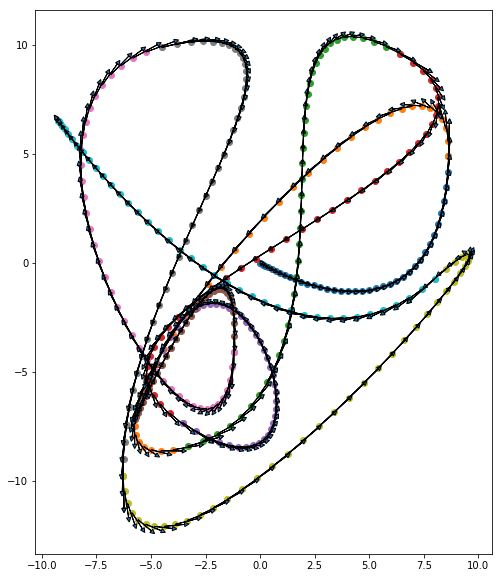

In [421]:
plot_trajs(get_numpy(trajs), get_numpy(d_trajs))